# import 

In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json, html, re
import numpy as np
from tqdm import tqdm
from glob import glob
from collections import Counter
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
from datetime import timedelta, datetime
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
STOPWORDS = thai_stopwords()

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font_path = '/Users/Nozomi/Library/Fonts/THSarabunNew.ttf'
font_label = fm.FontProperties(fname=font_path,weight='bold',size=25)

def clean(text, hashtag=None):
    if hashtag:
        text = text.replace(hashtag, '')
    text = html.unescape(text)
    text = re.sub(r'http.+?(?:\\s|$)', '', text) # URL link
    text = re.sub(r'[“”„]', '"', text) # convert double quotations into "
    text = re.sub(r'[‘’′′′′`]', "'", text) # convert single quotations into '
    text = re.sub(r'[ \u00a0\xa0\u3000\u2002-\u200a\t\n#]+', ' ', text) # shrink whitespaces e.g. good  boy -> good boy
    text = re.sub(r'[\r\u200b\ufeff]+', '', text) # remove non-breaking space
    text = re.sub(r'ํา','ำ', text) # am
    return text.strip()

def tokenize(text, hashtag=None):
    tokens = word_tokenize(clean(text, hashtag), keep_whitespace='False')
    tokens = [token for token in tokens if token not in STOPWORDS and re.match(r'[ก-๙][ก-๙\\.\\-]+$', token)]
    return tokens

def get_hour(row, string=True):
    date = datetime(row.date.year, row.date.month, row.date.day, int(row.time[:2]))
    if string:
        return str(date)[:-3] # '2021-04-09 22:00'
    else:
        return date # datetime.datetime(2021, 4, 9, 22, 0)
    
def timerange(df):
    oldest = get_hour(df.iloc[len(df)-1], False)
    latest = get_hour(df.iloc[0], False)
    range_list = [str(oldest)]
    while range_list[-1] != str(latest):
        oldest = oldest + timedelta(hours=1)
        range_list.append(str(oldest))
    return pd.DataFrame(range_list, columns=['date'])

In [2]:
!ls tweets

#16ตุลาไปแยกปทุมวัน.csv
#16ตุลาไปแยกปทุมวัน.json
#25พฤศจิกาไปSCB.csv
#25พฤศจิกาไปSCB.json
#saveวันเฉลิม.csv
#saveวันเฉลิม.json
#ม็อบ25พฤศจิกาทวงคืนสมบัติชาติ.csv
#ม็อบ25พฤศจิกาทวงคืนสมบัติชาติ.json
#ม็อบ2ธันวา.csv
#ม็อบ2ธันวา.json
#ธรรมศาสตร์และการชุมนุม.csv
#ธรรมศาสตร์และการชุมนุม.json
#กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ.csv
#เกียมอุดมไม่ก้มหัวให้เผด็จการ.csv
#กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ.json
#เกียมอุดมไม่ก้มหัวให้เผด็จการ.json
badstudent_tweet.csv
badstudent_tweet.json
badstudent_tweet_raw.csv
freeyouth_tweet.csv
freeyouth_tweet.json
freeyouth_tweet_raw.csv
tanawatofficial_tweet.csv
tanawatofficial_tweet.json
tanawatofficial_tweet_raw.csv
thammasatUFTD_tweet.json


In [3]:
filename = 'tweets/freeyouth_tweet.json'
filename = 'tweets/badstudent_tweet.json'
filename = 'tweets/tanawatofficial_tweet.json'
filename = 'tweets/thammasatUFTD_tweet.json'
num = 20

# frequent hashtag & cooccurent words

In [4]:
df = pd.read_json(filename, lines=True).drop_duplicates('id')
df = df.reset_index(drop=True)

### define duration ###
df = df[(df.date >= '2020-1-1') & (df.date <= '2020-12-31')]

### tokenize ###
df['tokens'] = df.tweet.apply(lambda x: tokenize(x))

##### hashtags #####
hashtag_counter = Counter()
for lst in df.hashtags:
    hashtag_counter.update(lst)
    
hashtag2word = {x[0]:Counter() for x in hashtag_counter.most_common(num)}

# count frequent words
for i, row in df.iterrows():
    for hashtag in row['hashtags']:
        if hashtag in hashtag2word:
            hashtag2word[hashtag].update(row['tokens'])
    
print("|hashtag|count|frequent words|oldest|popular|\n|:-:|:-:|:-:|:-:|:-:|")
for tag, c, in hashtag_counter.most_common(num):
    tempdf = df[df.hashtags.apply(lambda x: tag in x)].sort_values(['created_at'])
    
    ## frequent words
    freqs = " ".join([f"{w}({c})" for w,c in hashtag2word[tag].most_common(10)])
    
    ## oldest
    oldest = tempdf.iloc[0].tweet
    oldest_name = tempdf.iloc[0].username
    oldest_link = tempdf.iloc[0].link
    oldest_date = str(tempdf.iloc[0]['created_at']).split('+')[0]
    
    ## popular
    tempdf = tempdf.sort_values(["retweets_count"], ascending=False)
    popular = tempdf.iloc[0].tweet
    popular_name = tempdf.iloc[0].username
    popular_link = tempdf.iloc[0].link
    popular_date = str(tempdf.iloc[0]['created_at']).split('+')[0]
    retweet_count = tempdf.iloc[0].retweets_count
    
    print(f"|{tag}|{c}|{freqs}|[{oldest_date}]({oldest_link})<br>[@{oldest_name}](https://twitter.com/{oldest_name})<br><br>{oldest.replace('|||','')}|[{popular_date}]({popular_link})<br>[@{popular_name}](https://twitter.com/{popular_name})<br>{retweet_count} retweets<br><br>{popular.replace('|||','')}|")

|hashtag|count|frequent words|oldest|popular|
|:-:|:-:|:-:|:-:|:-:|
|ราษฎร|22|ม็อบ(37) ธันวา(33) ราษฎร(29) โอชา(19) ไล่(18) จันทร์(18) พฤศจิกา(8) ปอ.(6) ประสงค์(5) ประชาชน(3)|[2020-10-19 18:12:35](https://twitter.com/ThammasatUFTD/status/1318148032920055808)<br>[@thammasatuftd](https://twitter.com/thammasatuftd)<br><br>เราขอย้ำในจุดยืนและขอสั่งให้รัฐบาลทำตาม 3 ข้อ ดังต่อไปนี้  1. ประยุทธ์ จันทร์โอชา ต้องลาออก พร้อมทั้งคณะรัฐมนตรี 2. เปิดสภา แก้ไขรัฐธรรมนูญ ตามข้อเสนอของประชาชน 3. ปฏิรูปสถาบันกษัตริย์โดยด่วน  #ราษฎร #ปล่อยเพื่อนเรา  https://t.co/7a4O0xqmc6|[2020-11-18 20:24:05](https://twitter.com/ThammasatUFTD/status/1329052761481125888)<br>[@thammasatuftd](https://twitter.com/thammasatuftd)<br>11535 retweets<br><br>20:23 น. แกนนำประกาศยุติการชุมนุมและนัดหมายครั้งถัดไปในวันที่ 25 พฤศจิกายน 2563 หน้าสำนักงานทรัพย์สินพระมหากษัตริย์  — #ราษฎร #ม็อบ18พฤศจิกา #18พฤศจิกาไปราษฎร์ประสงค์|
|ธรรมศาสตร์และการชุมนุม|22|ธรรมศาสตร์(28) ชุมนุม(27) ราษฎร(18) กันยา(13) ทวง(13) อำนาจ(13) คืน(13) สนามหลว

In [5]:
df = df.reset_index(drop=True)
df

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,tokens
0,1344645950409592832,1344645948408881152,2020-12-31 21:05:51+07:00,2020-12-31,21:05:51,700,1296005753103212544,thammasatuftd,แนวร่วมธรรมศาสตร์และการชุมนุม (UFTD),,...,,,,,[],,,,,"[ที่มา, กิจกรรม, รวบรวม, ภาพ, ใช้งาน, ต่อไป, ใ..."
1,1344645948408881153,1344645948408881152,2020-12-31 21:05:51+07:00,2020-12-31,21:05:51,700,1296005753103212544,thammasatuftd,แนวร่วมธรรมศาสตร์และการชุมนุม (UFTD),,...,,,,,[],,,,,"[แนวร่วม, ธรรมศาสตร์, ชุมนุม, เชิญชวน, พ่อแม่,..."
2,1344645086395596801,1344645086395596800,2020-12-31 21:02:25+07:00,2020-12-31,21:02:25,700,1296005753103212544,thammasatuftd,แนวร่วมธรรมศาสตร์และการชุมนุม (UFTD),,...,,,,,[],,,,,"[แถลงการณ์, ราษฎร, เรื่อง, การจับกุม, มวลชน, อ..."
3,1343120604749152256,1343120604749152256,2020-12-27 16:04:40+07:00,2020-12-27,16:04:40,700,1296005753103212544,thammasatuftd,แนวร่วมธรรมศาสตร์และการชุมนุม (UFTD),,...,,,,,[],,,,,"[กุ้ง, กิน, กิน, แนวร่วม, ธรรมศาสตร์, ชุมนุม, ..."
4,1340602889807400961,1340602889807400960,2020-12-20 17:20:10+07:00,2020-12-20,17:20:10,700,1296005753103212544,thammasatuftd,แนวร่วมธรรมศาสตร์และการชุมนุม (UFTD),,...,,,,,[],,,,,"[แนวร่วม, ธรรมศาสตร์, ขอบพระคุณ, พสกนิกร, ชาวไ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,1296779537888342016,1296358877894545408,2020-08-21 19:01:49+07:00,2020-08-21,19:01:49,700,1296005753103212544,thammasatuftd,แนวร่วมธรรมศาสตร์และการชุมนุม (UFTD),,...,,,,,"[{'screen_name': 'JJJJJJJJJJJI97', 'name': 'iz...",,,,,"[ตอนนี้, บัญชี, ปิดบัญชี, ถาวร, เนื่องด้วย, บา..."
319,1296779505806094336,1296358877894545408,2020-08-21 19:01:41+07:00,2020-08-21,19:01:41,700,1296005753103212544,thammasatuftd,แนวร่วมธรรมศาสตร์และการชุมนุม (UFTD),,...,,,,,"[{'screen_name': 'Chanint90302632', 'name': 'อ...",,,,,"[ตอนนี้, บัญชี, ปิดบัญชี, ถาวร, เนื่องด้วย, บา..."
320,1296779489901305856,1296358877894545408,2020-08-21 19:01:38+07:00,2020-08-21,19:01:38,700,1296005753103212544,thammasatuftd,แนวร่วมธรรมศาสตร์และการชุมนุม (UFTD),,...,,,,,"[{'screen_name': 'LukvaPotter', 'name': 'Hedwi...",,,,,"[ตอนนี้, บัญชี, ปิดบัญชี, ถาวร, เนื่องด้วย, บา..."
321,1296014554220990464,1296010189246668800,2020-08-19 16:22:03+07:00,2020-08-19,16:22:03,700,1296005753103212544,thammasatuftd,แนวร่วมธรรมศาสตร์และการชุมนุม (UFTD),,...,,,,,"[{'screen_name': 'snnnnnnnnn_thx', 'name': 'SN...",,,,,"[คนละ, กองทุน, คณะ, ประชาชน, ปลดแอก, ทีมงาน, ด..."


In [6]:
column = ['date','time','username','tweet','hashtags','link','quote_url','urls','photos','thumbnail','mentions','reply_to','replies_count','retweets_count','likes_count']

df.to_csv(filename.replace('.json','_raw.csv'), index=False)
df[column].to_csv(filename.replace('.json','.csv'), index=False)

# hashtag timeseries

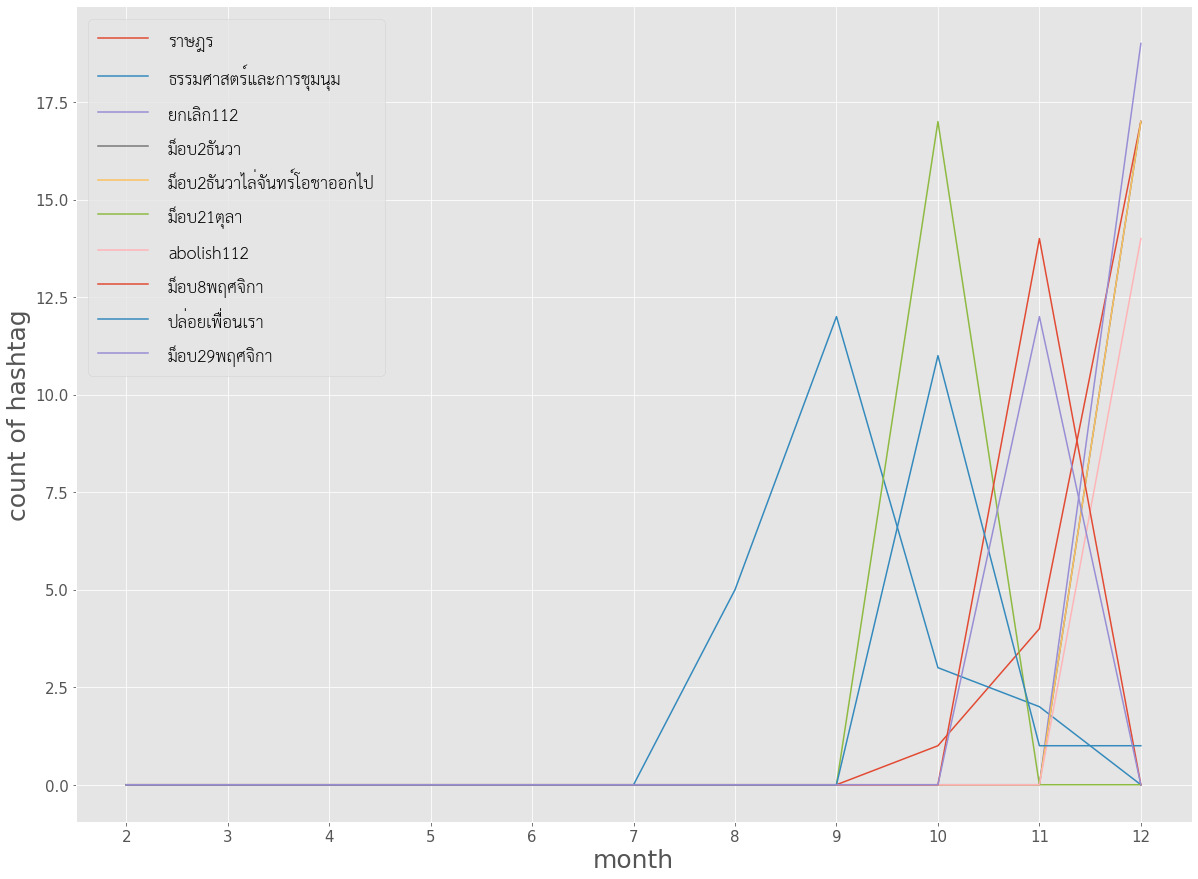

In [7]:
### plot time series ###

start_m = 2
xs = list(range(start_m, 13))

fig = plt.figure(figsize=(20,15))

for tag, count in hashtag_counter.most_common(10):
    counts = []  
    for m in range(start_m, 13):
        count = 0
        thismonth_df = df[df.date.dt.month == m]
        for i, row in thismonth_df.iterrows():
            if tag in row['hashtags']:
                count += 1
        counts.append(count)

    plt.plot(xs, counts, label=tag)

plt.xticks(xs, size=15)
plt.yticks(size=15)
plt.legend(prop=font_label)
plt.xlabel('month', size=25)
plt.ylabel('count of hashtag', size=25)
plt.show()

# LDA

In [8]:
%%time

num_topic = 5

corpus_dictionary = Dictionary(df.tokens)
corpus = []
for tokens_list in tqdm(df.tokens):
    corpus.append(corpus_dictionary.doc2bow(tokens_list))
lda = LdaModel(corpus, num_topics=num_topic, id2word=corpus_dictionary, passes=10)

100%|██████████| 323/323 [00:00<00:00, 28170.18it/s]


CPU times: user 3.28 s, sys: 22.9 ms, total: 3.3 s
Wall time: 3.34 s


In [9]:
### print result of keywords ###
print('|rank|topic 1||topic 2||topic 3||topic 4||topic 5||\n|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|')
for i in range(10):
    print(f'|{i+1}', end='')
    for j in range(5):
        word, score = lda.show_topic(j)[i]
        print(f"|{word}|{score:.3f}",end="")
    print('|')

|rank|topic 1||topic 2||topic 3||topic 4||topic 5||
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|ชุมนุม|0.038|พฤศจิกา|0.027|ตุลา|0.023|ตุลา|0.026|ม็อบ|0.053|
|2|ธรรมศาสตร์|0.032|ม็อบ|0.019|ม็อบ|0.022|ม็อบ|0.023|ธันวา|0.029|
|3|ราษฎร|0.019|ราษฎร|0.018|สถานทูต|0.019|ยกเลิก|0.021|ราษฎร|0.026|
|4|ม็อบ|0.019|ราบ|0.017|ราษฎร|0.019|รอ|0.013|ตุลา|0.022|
|5|แนวร่วม|0.017|ประชาชน|0.015|แยก|0.014|เพื่อน|0.010|จันทร์|0.021|
|6|พฤศจิกา|0.014|รัฐ|0.010|เยอรมัน|0.013|ชุมนุม|0.010|โอชา|0.021|
|7|น.|0.014|บริเวณ|0.010|สามย่าน|0.011|ฟัง|0.008|ประยุทธ์|0.014|
|8|ทวง|0.010|น.|0.009|เดินขบวน|0.011|ปล่อย|0.008|ไล่|0.014|
|9|คืน|0.010|ชุมนุม|0.009|พัก|0.010|วันที่|0.008|รัฐธรรมนูญ|0.009|
|10|กันยา|0.008|กันที่|0.008|ชุมนุม|0.009|เวลา|0.008|ประชาชน|0.009|


In [10]:
### prediction - argmax ###

n = len(df)

result_matrix = np.zeros((n, num_topic))
for row, dist in enumerate(lda.get_document_topics(corpus[:n])):
    for tpl in dist:
        col = tpl[0]
        result_matrix[row,col] = tpl[1]
        
result_df = pd.DataFrame(result_matrix)
result_df['topic'] = result_df.apply(lambda row: np.argmax(row), axis=1)
result_df['tweet'] = df.tweet.reset_index(drop=True)
result_df['date'] = df.apply(lambda row: get_hour(row), axis=1).reset_index(drop=True)

result_df

,0,1,2,3,4,topic,tweet,date
0,0.390644,0.012692,0.012607,0.012552,0.571505,4,ซึ่งผู้ที่มาร่วมกิจกรรมนี้ ทางเราจะรวบรวมภาพเพ...,2020-12-31 21:00
1,0.970181,0.000000,0.000000,0.000000,0.000000,0,แนวร่วมธรรมศาสตร์และการชุมนุมขอเชิญชวนพ่อแม่พี...,2020-12-31 21:00
2,0.018658,0.018267,0.926304,0.018380,0.018390,2,แถลงการณ์ราษฎร เรื่อง การจับกุมมวลชนอาสา (We ...,2020-12-31 21:00
3,0.946418,0.013361,0.013419,0.013378,0.013425,0,กุ้งกินได้ เรากินแล้ว!!! แนวร่วมธรรมศาสตร์และ...,2020-12-27 16:00
4,0.942224,0.014315,0.014385,0.014621,0.014454,0,แนวร่วมธรรมศาสตร์ฯ ขอขอบพระคุณพสกนิกรชาวไทยอย่...,2020-12-20 17:00
...,...,...,...,...,...,...,...,...
318,0.952776,0.011772,0.011807,0.011830,0.011815,0,@JJJJJJJJJJJI97 ตอนนี้ทางบัญชี UOB ได้ถูกปิดบั...,2020-08-21 19:00
319,0.952776,0.011772,0.011807,0.011830,0.011815,0,@Chanint90302632 ตอนนี้ทางบัญชี UOB ได้ถูกปิดบ...,2020-08-21 19:00
320,0.952775,0.011772,0.011807,0.011831,0.011814,0,@LukvaPotter ตอนนี้ทางบัญชี UOB ได้ถูกปิดบัญชี...,2020-08-21 19:00
321,0.010888,0.010636,0.010707,0.010592,0.957177,4,@snnnnnnnnn_thx เป็นคนละกองทุนกับของคณะประชาชน...,2020-08-19 16:00


In [11]:
### print prediction ###

print('|tweet|topic|prob of 1|2|3|4|5|\n|:-:|:-:|:-:|:-:|:-:|:-:|:-:|')
for i, row in result_df[['tweet','topic',0,1,2,3,4]].sample(10).iterrows():
    print(f'|{row.tweet}|{row.topic+1}|{row[0]:.3f}|{row[1]:.3f}|{row[2]:.3f}|{row[3]:.3f}|{row[4]:.3f}|')

|tweet|topic|prob of 1|2|3|4|5|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|แต่หากรัฐบาลไม่มีคำตอบให้ภายใน 3 วันนับตั้งแต่ 21 ตุลาคม 2563  “ราษฎรจะกลับมาใหม่”|2|0.034|0.866|0.034|0.033|0.034|
|พระมหากษัตริย์ทรงอยู่เหนือการเมือง...? #ปฏิรูปสถาบัน #23ตุลาวันตาสว่าง  https://t.co/E4VresFHkI|3|0.025|0.025|0.464|0.025|0.460|
|วันนี้ 4 พฤศจิกายน เวลา 16:00 น. จะมีการตั้งโต๊ะแถลงการณ์ใหญ่จากกลุ่มราษฎร ที่บริเวณสนามหลวง  โปรดติดตาม –– #เราคือราษฎร #ธรรมศาสตร์และการชุมนุม  https://t.co/vcRckAdxpo|1|0.942|0.015|0.015|0.014|0.014|
|Save รูป แล้วส่งต่อได้เลย !!! Facebook Page :  https://t.co/3EcoKsoGuH Telegram :  https://t.co/VzlZazwzsS #ธรรมศาสตร์และการชุมนุม  https://t.co/TcSAAHRxFK|2|0.068|0.732|0.067|0.067|0.067|
|นัดแล้ว ไม่แกง!|3|0.067|0.067|0.732|0.067|0.067|
|วันพรุ่งนี้แล้ว 20 ธันวาคม 2563 ไปเลือกตั้ง อบจ. กัน !!! – #20ธันวาไปเลือกตั้ง #เลือกตั้งท้องถิ่น #เลือกตั้งอบจ|5|0.018|0.018|0.018|0.019|0.927|
|อย่าคิดริอาจจะทำรัฐประหาร! อย่าริอาจเป็นกบฏต่อประชาชน!  เมื่อใดที่มีการรัฐประหาร คุณจะสูญสิ้นแบบไม่ม

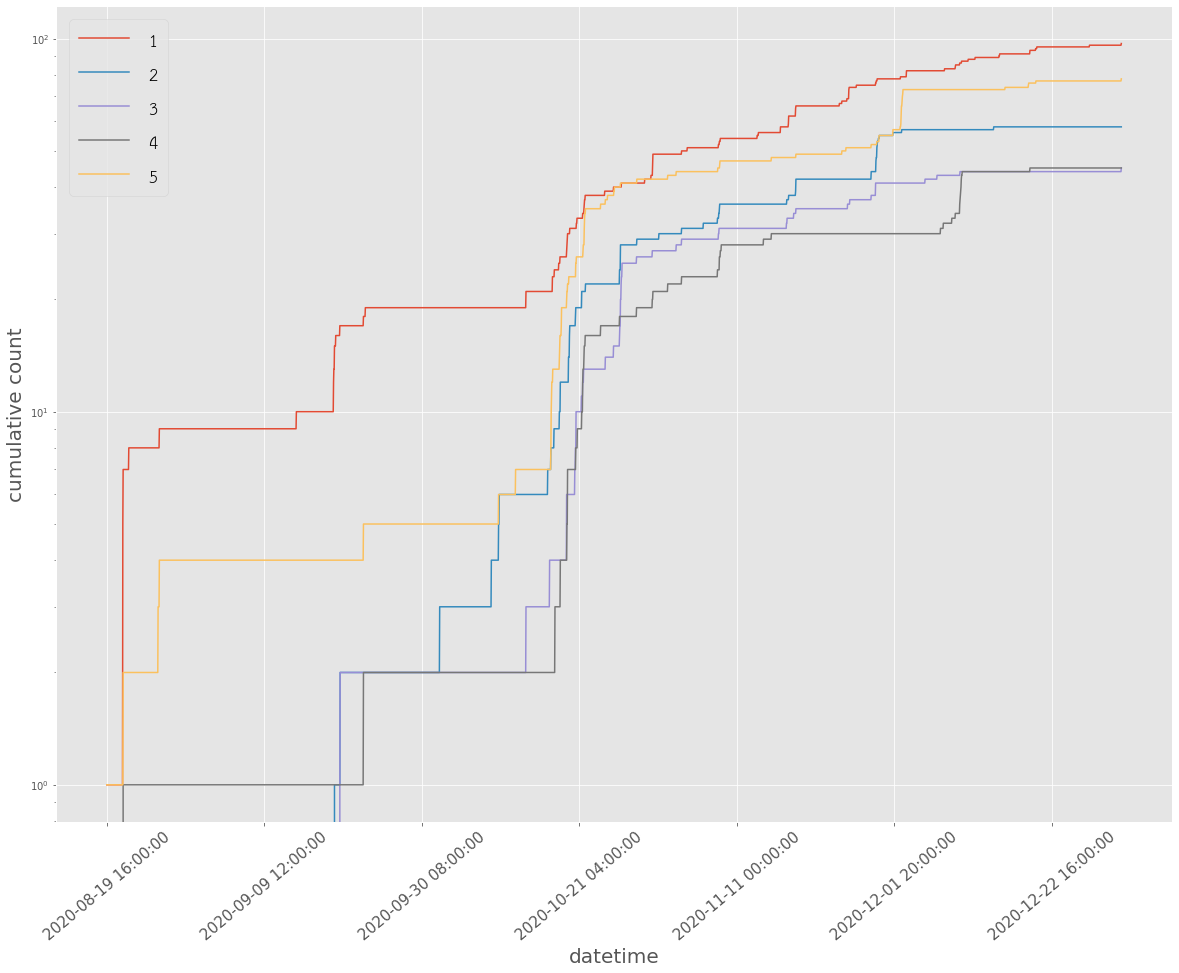

In [12]:
### plot topic time series ###

tempdf = timerange(df)

for t in range(5):
    tempdf[t+1] = tempdf.date.apply(lambda x: sum((result_df.date <= x) & (result_df.topic==t)))
    
tempdf.plot(x='date', figsize=(20,15))
plt.legend(prop=font_label)
plt.ylabel('cumulative count', size=20)
plt.xlabel('datetime', size=20)
plt.xticks(rotation=40, size=15)
plt.yscale('log')
plt.show()